# only for the analysis at hand that I wanna finish ffs

### source code to get started
---

In [8]:
from igor.binarywave import load as loadibw
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 #set dpi of figs for entire notebook

#### *Functions*

In [4]:
# function that finds all peak amplitudes for a pair of waves

def amps(stim,rec,t = 50, returnall = 0):
    
    '''
    Function that finds ALL the peaks in a given pair of stim and rec waves.
    
    Multiplies rec wave by 1e9 to convert to picoamps!
    
    Uses stimulus onset to find stims, and finds peak within window defined by t.
    amplitude calculated by subtracting peak from the baseline (mean of pre-first stim)
    
    Median may be better choice! check with olexiy.
    
    Parameters:
    
    stim      : expects wave (array)
    rec       : expects wave (array)
    
    Optional Parameters:
    
    t         : time duration of window in ms                     DEFAULT: 50
    returnall : if 1, returns amps, peaks, baseline, stim_locs    DEFAULT: 0

    Returns:
    
    amps      : peak amplitude of response                        (array)
    
    Optional Returns:
    
    peaks     : absolute value of peaks                           (array)
    baseline  : mean of the wave from start to first stim onset.  (float)
    stim_locs : stimulus onsets identified                        (list)
    
    '''
    
    freq = 50
    
    rec = rec*1e9

    stim_locs = []
    for i in enumerate(stim):
        i = i[0]
        if stim[i-1] < 1 and stim[i] > 1:
            stim_locs += [i]
            
    baseline = np.mean(rec[:stim_locs[0]])
    peaks = []

    for i in stim_locs:
        peaks += [np.min(rec[i:i+t*freq])]
    
    peaks = np.array(peaks)
    amps = peaks - baseline
    
    if returnall:
        return amps, peaks, baseline, stim_locs
    
    return amps

# protocolID: function that

def protocolID(waves, twop = False, tr20 = False):

    """
    Function that Identifies protocols based on number of sweeps,
    1  = 20 Train
    3  = Test Pulse (single)
    10 = Paired Pulse Protocol
    
    Parameters:
    
    waves     : dictionary of waves
    
    Optional Parameters:
    
    twop      : if TRUE, returns only two_pulse list     DEFAULT: False
    tr20      : if TRUE, returns only train_20p list     DEFAULT: False
    
    Returns:
    
    two_pulse  [list]
    train_20p  [list]
    one_pulse  [list]
    unassigned [list]

    """

    wavlst = list(waves.keys())

    train_20p = []
    one_pulse = []
    two_pulse = []
    unassigned = []
    dump = []

    # loop through the thingy
    for ele in wavlst:

        if len(dump) == 0: # if dump is empty, just add the element
            dump += [ele]

        else: #if dump is not empty, check if it's from the same series as previous

            if ele[2:4] == dump[-1][2:4]: #if same as previous, add to dump
                dump += [ele]

            elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
                two_pulse += [dump]
                dump = [ele]

            elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
                one_pulse += [dump]
                dump = [ele]

            elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
                train_20p += [dump]
                dump = [ele]

            else: # if none of the above, put to unassigned
                unassigned += [dump]
                dump = [ele]

    # do something about sweeps remaining in dump at the end of the for loop

    if len(dump) == 0: #if same as previous, add to dump
        dump = []       
    elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
        two_pulse += [dump]
        dump = []      
    elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
        one_pulse += [dump]
        dump = [] 
    elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
        train_20p += [dump]
        dump = []       
    else: # if none of the above, put to unassigned
        unassigned += [dump]
        dump = []
    
    if twop:
        return two_pulse
    elif tr20:
        return train_20p
    else:
        return two_pulse, one_pulse, train_20p, unassigned

## testbed for one cell

In [98]:
#absolute path to wave DIRECTORY
wave_dir = "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves"
#load every wave into a dictionary
waves = {}
for filename in os.listdir(wave_dir):
    waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
#convert into a nice structured dataframe
wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
#is this even necessary? maybe to save into an addressable HDF5 file or with nwb format?

#digitization frequency (samples per millisecond)
freq = 50 #per ms (50 KHz)

In [99]:
p1 = []
p2 = []
test = []
twop = protocolID(waves, twop = True)

for ele in twop:
    for i in range(int(len(ele)/2)):
        amp = -1*amps(waves[ele[i*2]],waves[ele[i*2+1]])
        test += amp.tolist()
        p1 += [amp[0]]
        p2 += [amp[1]]

In [ ]:
plt.subplots_adjust(wspace=0)

plt.subplot(1,2,1)
sns.swarmplot(x = np.zeros(len(p1)), y = p1, color = "darkorange")
sns.boxplot(x = np.ones(len(p1)), y = p1, width = 0.2)
plt.xticks([])
plt.ylim(-0.1,1.2)
plt.xlabel("1st Pulse")
plt.ylabel("nA")

plt.subplot(1,2,2)
sns.swarmplot(x = np.ones(len(p2)), y = p2, color = 'darkorange')
sns.boxplot(x = np.ones(len(p2)), y = p2, width = 0.2)
plt.gca().set(yticklabels=[])

plt.ylim(-0.1,1.2)
plt.xticks([])

plt.xlabel("2nd Pulse")

plt.gcf().set_size_inches(4,4)

In [ ]:
plt.hist([p1, p2])
plt.gcf().set_size_inches(4,4)

## Analysis begins here:
---

In [2]:
#list of directories of responding neurons

dirs = ["C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122A/101122A_Waves",#
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves",
        "C:/users/njana/Desktop/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122G/111122G_Waves"]#


In [5]:
p1_res = []
p1_cum = []
p2_res = []
p2_cum = []

for wavdir in dirs:
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wavdir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wavdir+"/"+str(filename))['wave']['wData'] #keeps only the waves

    p1 = []
    p2 = []
    test = []
    twop = protocolID(waves, twop = True)

    for ele in twop:
        for i in range(int(len(ele)/2)):
            amp = -1*amps(waves[ele[i*2]],waves[ele[i*2+1]])
            test += amp.tolist()
            p1 += [amp[0]]
            p2 += [amp[1]]
    
    p1_res += [p1]
    p1_cum += p1
    p2_res += [p2]
    p2_cum += p2
    
p1_cum = np.array(p1_cum)
p2_cum = np.array(p2_cum)

In [6]:
threshold = 0.1

p1_cum = p1_cum[p1_cum < 2]
p2_cum = p2_cum[p2_cum < 2]

p1_succ = p1_cum[p1_cum>threshold]
p1_fail = p1_cum[p1_cum<threshold]

p2_succ = p2_cum[p2_cum>threshold]
p2_fail = p2_cum[p2_cum<threshold]

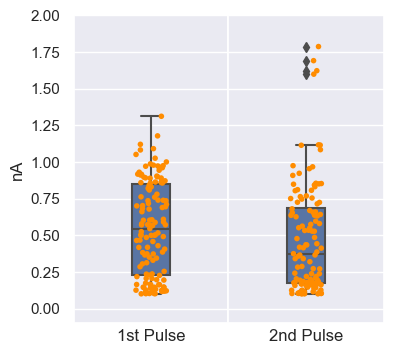

In [9]:
plt.subplots_adjust(wspace=0)

plt.subplot(1,2,1)
sns.stripplot(x = np.zeros(len(p1_succ)), y = p1_succ, color = "darkorange", size = 4)
#sns.stripplot(x = np.zeros(len(p1_fail)), y = p1_fail, color = "salmon")#, size = 2)
sns.boxplot(x = np.ones(len(p1_succ)), y = p1_succ, width = 0.25)
plt.xticks([])
plt.ylim(-0.1,2)
plt.xlabel("1st Pulse")
plt.ylabel("nA")

plt.subplot(1,2,2)
sns.stripplot(x = np.zeros(len(p2_succ)), y = p2_succ, color = "darkorange", size = 4)
#sns.stripplot(x = np.zeros(len(p2_fail)), y = p2_fail, color = "salmon")#, size = 2)
sns.boxplot(x = np.ones(len(p2_succ)), y = p2_succ, width = 0.25)
plt.gca().set(yticklabels=[])

plt.ylim(-0.1,2)
plt.xticks([])

plt.xlabel("2nd Pulse")

plt.gcf().set_size_inches(4,4)

In [299]:
tot1 = p1_succ.shape[0]+ p1_fail.shape[0]
tot2 = p2_succ.shape[0]+ p2_fail.shape[0]

p1sucpercent = p1_succ.shape[0]*100/tot1
p1failpercent = p1_fail.shape[0]*100/tot1

p2sucpercent = p2_succ.shape[0]*100/tot2
p2failpercent = p2_fail.shape[0]*100/tot2

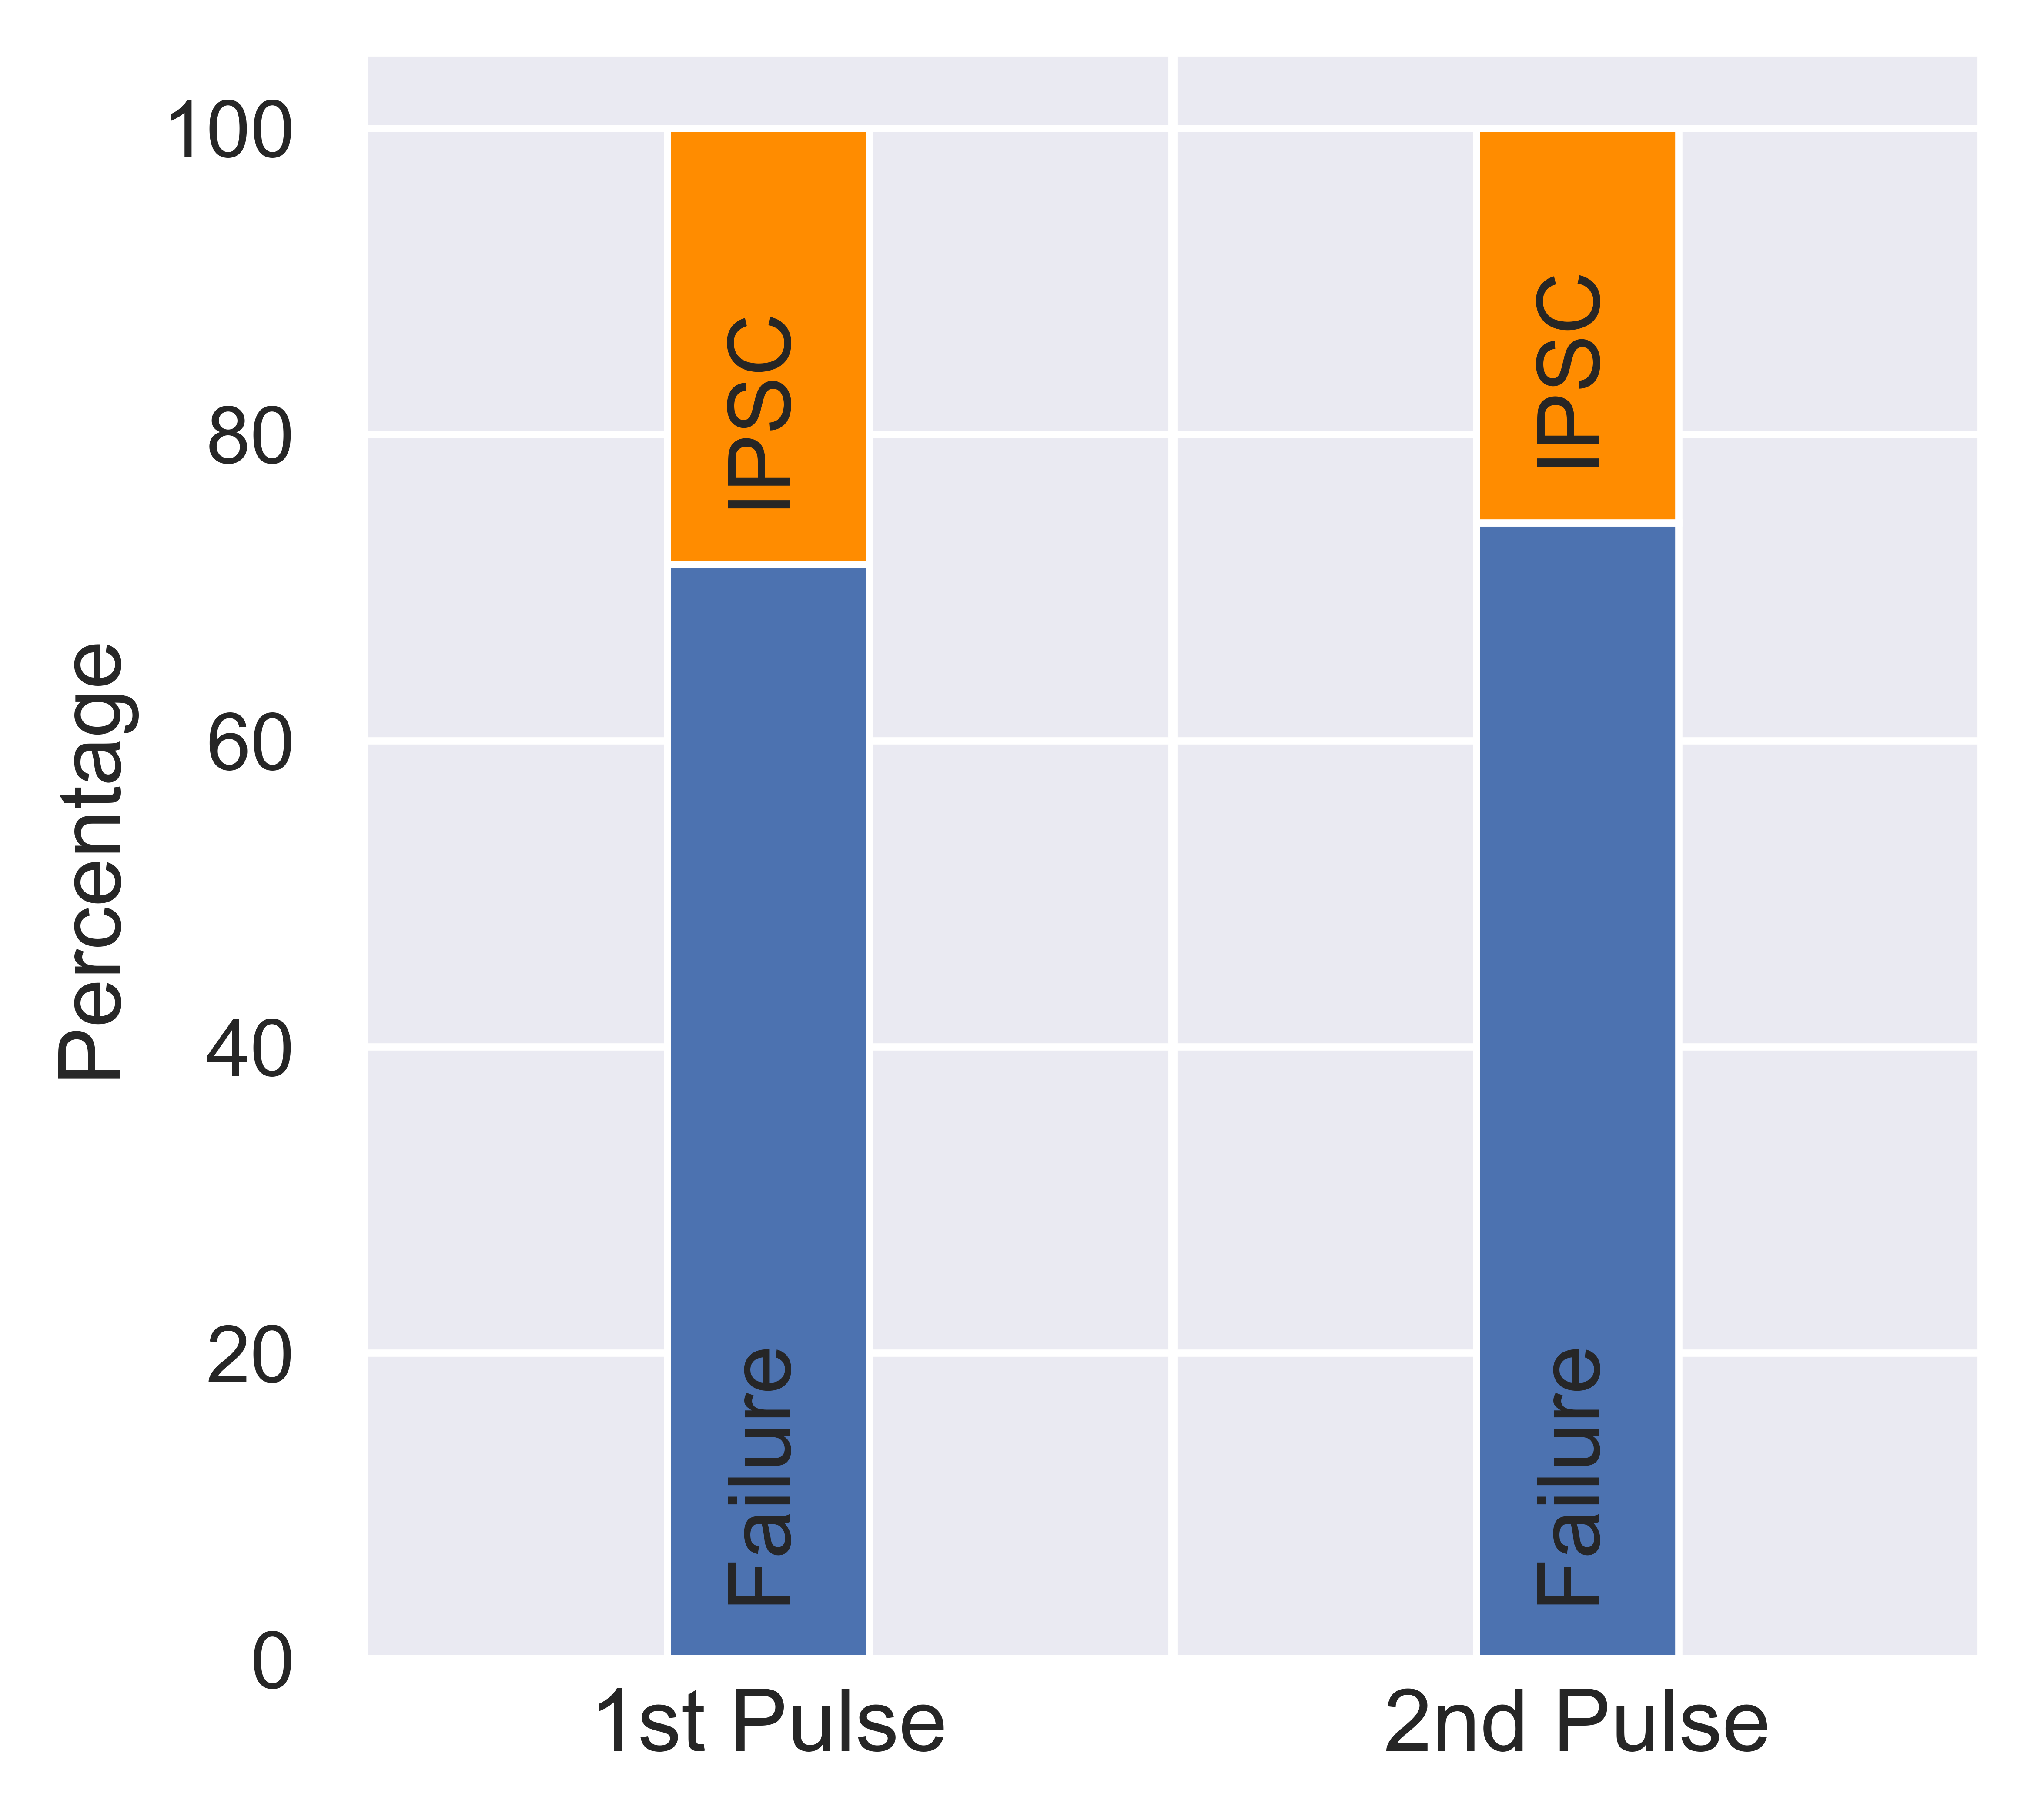

In [305]:
plt.subplots_adjust(wspace=0)

plt.subplot(1,2,1)

plt.bar(x = 0,height = p1failpercent, color = 'b', width = 0.5)
plt.bar(x = 0, height = p1sucpercent, bottom = p1failpercent, color = 'darkorange', width = 0.5)
plt.text(0,p1failpercent,"  IPSC", rotation = 90, horizontalalignment = "center", verticalalignment = "bottom")
plt.text(0,0,"  Failure", rotation = 90, horizontalalignment = "center", verticalalignment = "bottom")
plt.xlim(-1,1)
plt.xticks([])
plt.xlabel("1st Pulse")
plt.ylabel("Percentage")

plt.subplot(1,2,2)
plt.bar(x = 0,height = p2failpercent, color = 'b', width = 0.5)
plt.bar(x = 0, height = p2sucpercent, bottom = p2failpercent, color = 'darkorange', width = 0.5)
plt.text(0,p2failpercent,"  IPSC", rotation = 90, horizontalalignment = "center", verticalalignment = "bottom")
plt.text(0,0,"  Failure", rotation = 90, horizontalalignment = "center", verticalalignment = "bottom")

plt.xlim(-1,1)
plt.gca().set(yticklabels=[])
plt.xticks([])
plt.xlabel("2nd Pulse")

plt.gcf().set_size_inches(4,4)

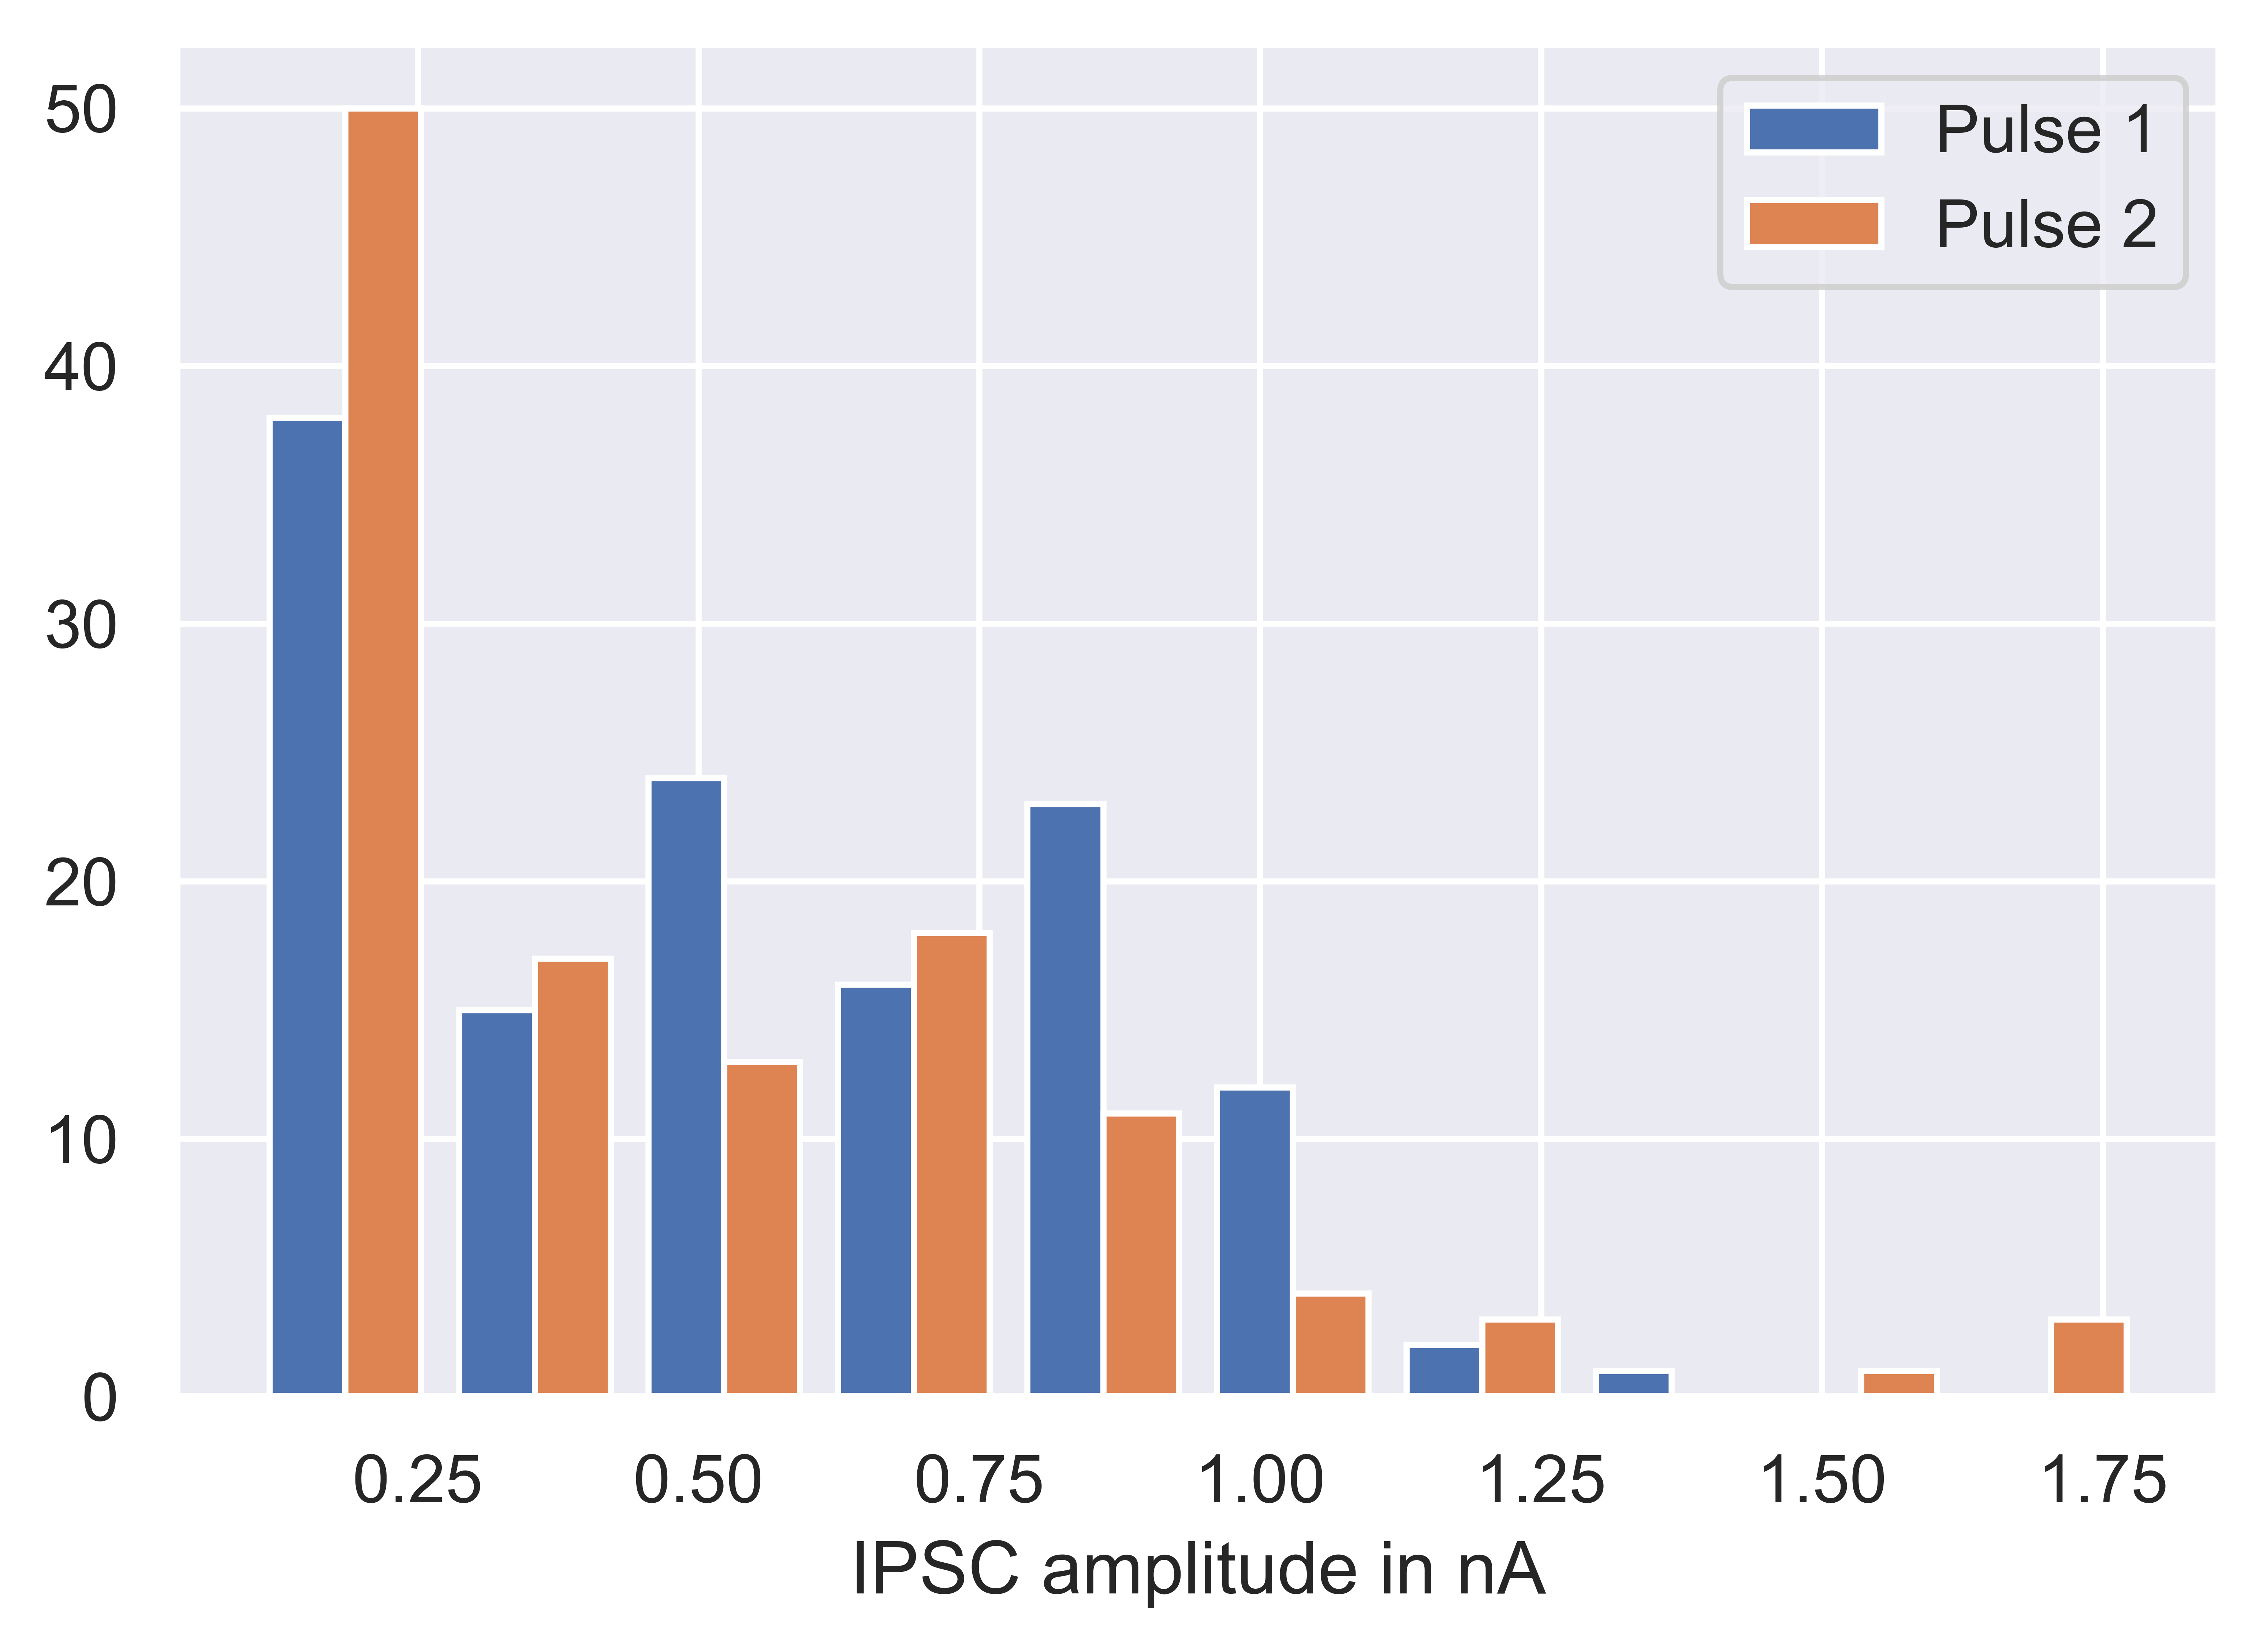

In [306]:
plt.hist([p1_succ,p2_succ])
plt.legend(["Pulse 1","Pulse 2"] )
plt.xlabel("IPSC amplitude in nA")
plt.gcf().set_size_inches(6,4)

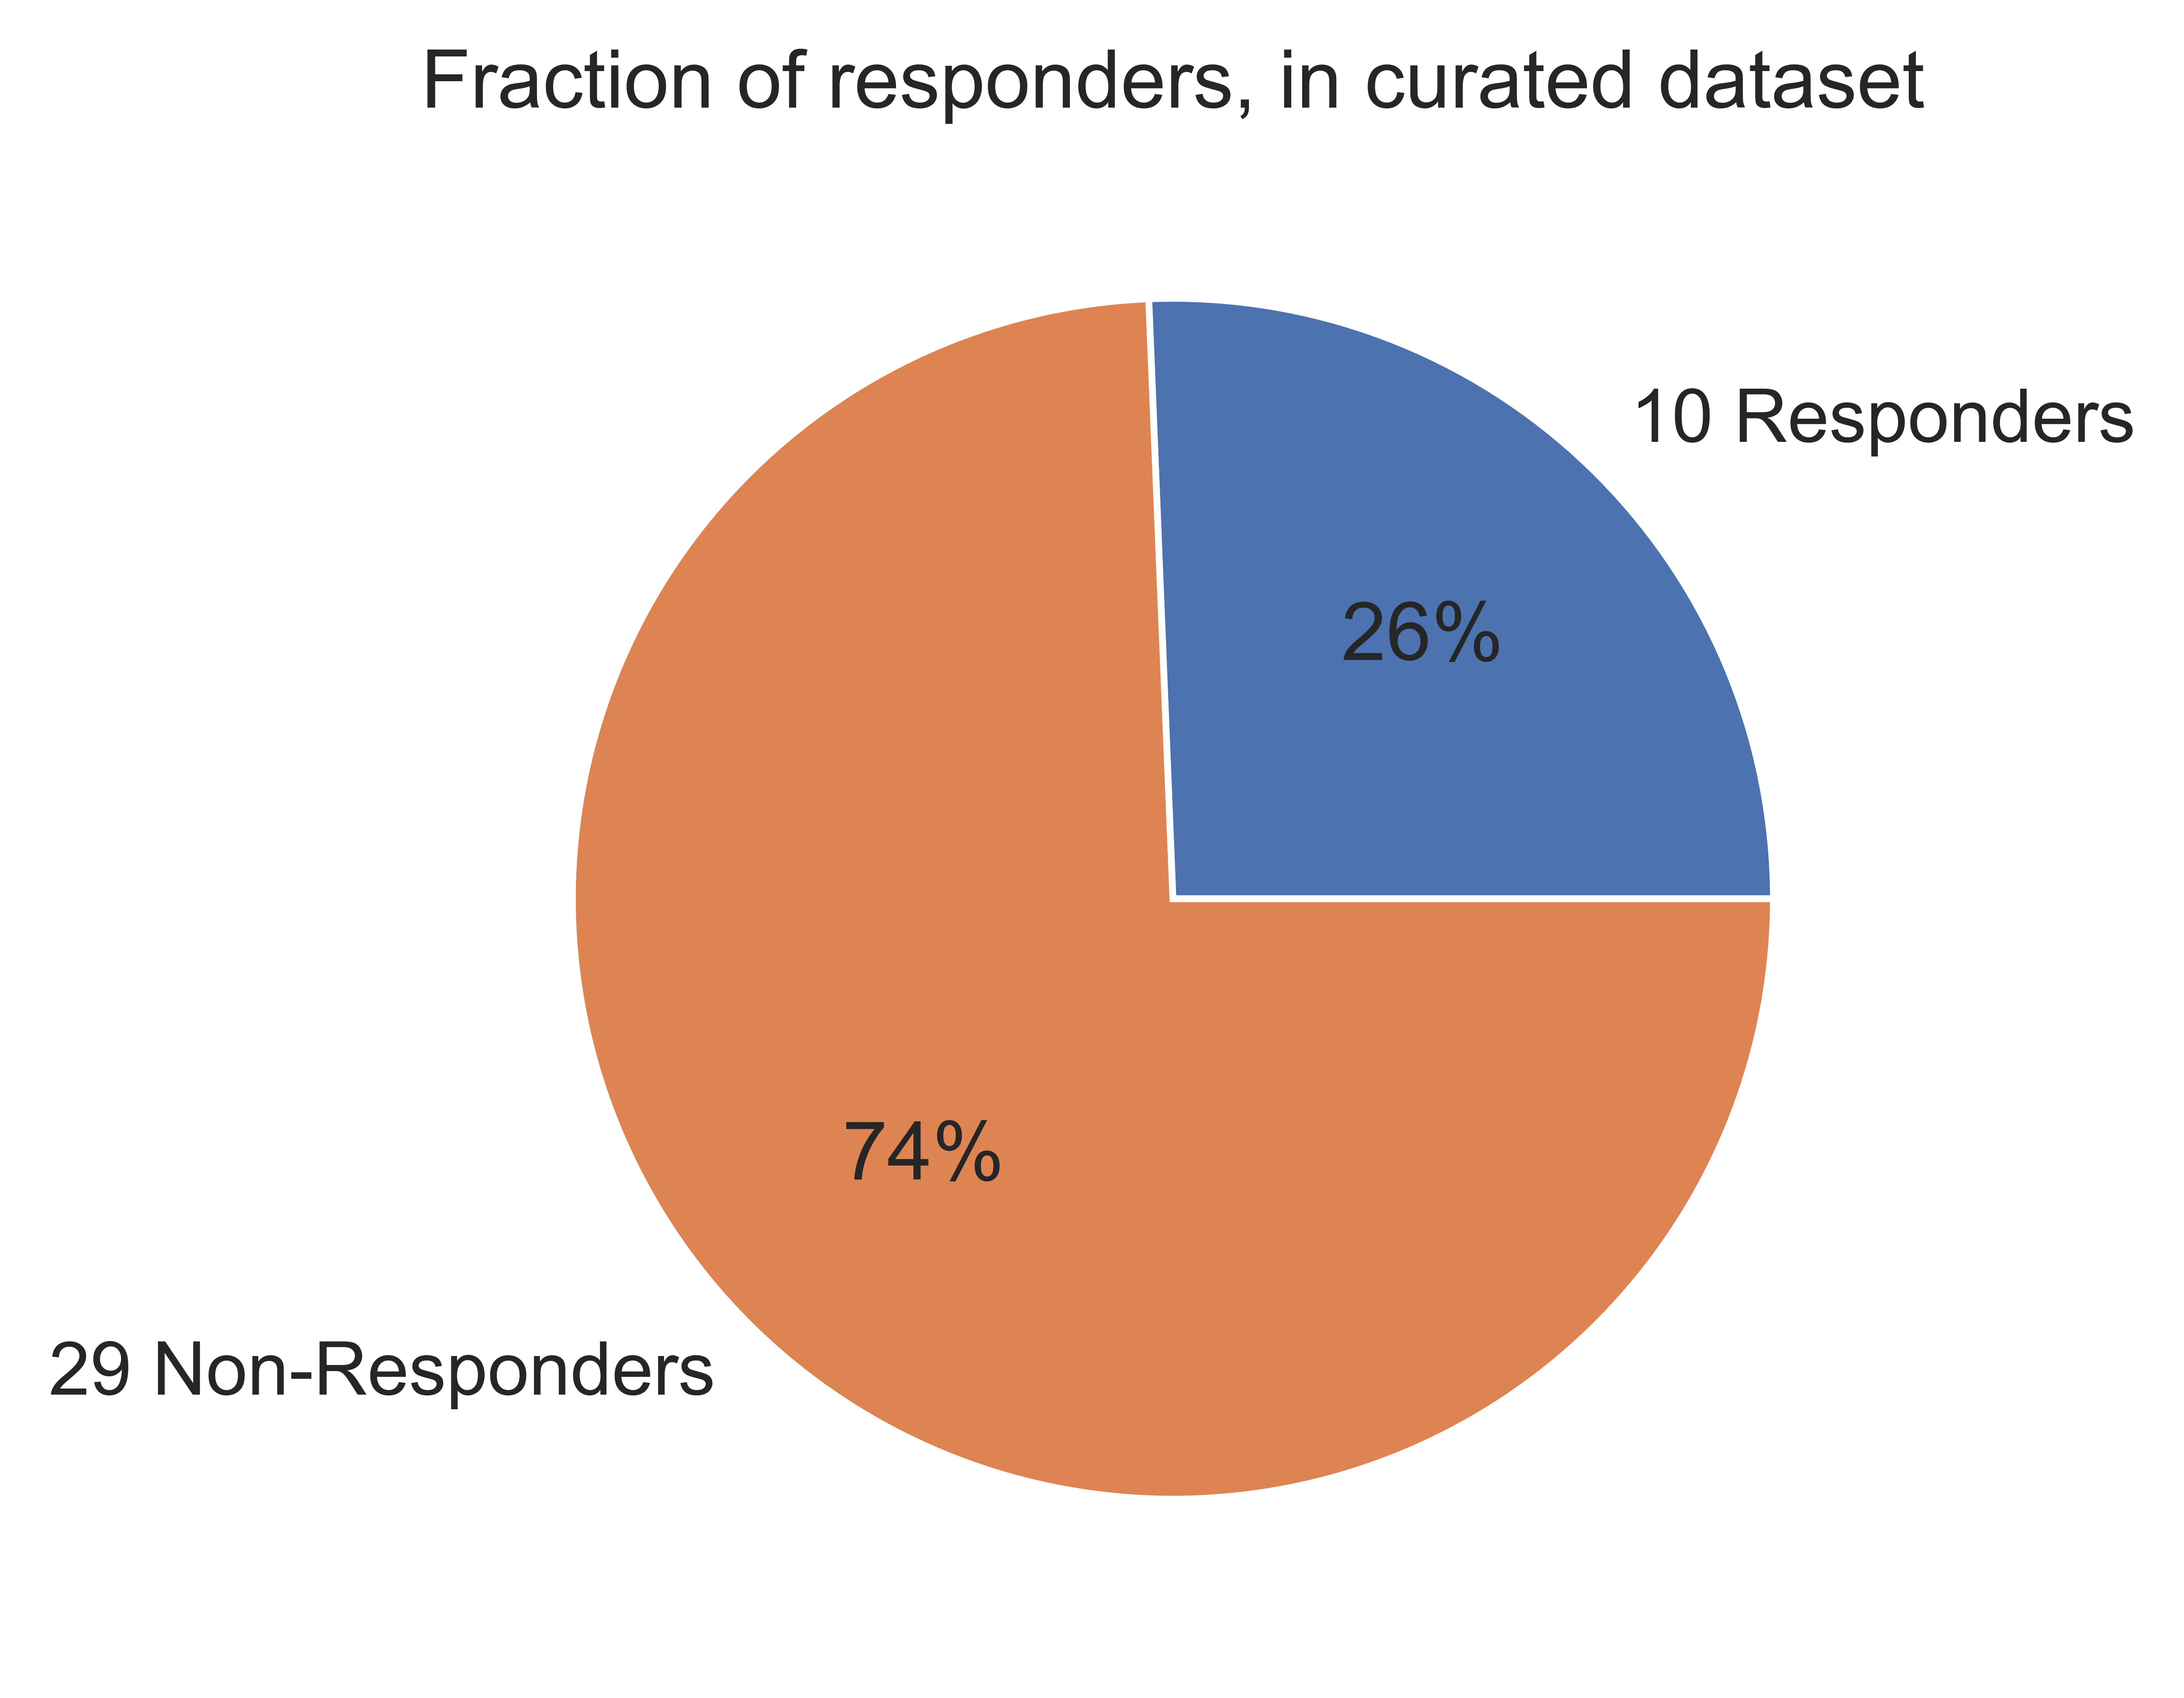

In [307]:
plt.pie([10,29], labels = ["10 Responders","29 Non-Responders"], autopct='%.0f%%' )
plt.title("Fraction of responders, in curated dataset")
plt.gcf().set_size_inches(5,4)